# Uni-LSTM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LSTM, Bidirectional
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

def get_data(normalized=0):
    df = pd.read_excel(r"/content/drive/MyDrive/Demand Forecasting/dataset.xlsx")
    df.columns = ["Time", "Load", "Temperature", "Humidity", "Liquid", "Wind", "Holiday", "School"]
    df = df[1:]  # drop duplicated header
    df["Time"] = pd.to_datetime(df["Time"])
    df["Day"] = df["Time"].dt.day
    df["Month"] = df["Time"].dt.month
    df["Hour"] = df["Time"].dt.hour * 3600  # encode hour as seconds

    # Final columns to use (reorder for modeling)
    df = df[[
        "Day", "Month", "Hour",
        "Temperature", "Humidity", "Liquid", "Wind",
        "Holiday", "School", "Load"
    ]]
    return df

def load_data(my_data, seq_len):
    amount_of_features = len(my_data.columns)
    data = my_data.values
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
    return [x_train, y_train, x_test, y_test]


df = get_data(0)
# min_max_scaler = preprocessing.MinMaxScaler()
# nomalized = min_max_scaler.fit_transform(df.values)
values = df.values
minima = np.amin(values[:, -1])
maxima = np.amax(values[:, -1])
scaling_parameter = maxima - minima
# Normalize all features except the target (last column)
for i in range(values.shape[1] - 1):
    values[:, i] = (values[:, i] - np.amin(values[:, i])) / (np.amax(values[:, i]) - np.amin(values[:, i]))

# Normalize target load
values[:, -1] = (values[:, -1] - minima) / scaling_parameter

df = pd.DataFrame(values)
window = 12
X_train, y_train, X_test, y_test = load_data(df[::-1], window)

def build_model(layers):
    d = 0.5
    model = Sequential()
    model.add(LSTM(512, return_sequences=False, recurrent_dropout=0.2))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

early_stop = EarlyStopping(
    monitor='val_loss',       # monitor validation loss
    patience=10,              # stop if no improvement for 10 epochs
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # reduce LR when val_loss plateaus
    factor=0.5,               # reduce by 50%
    patience=5,               # wait 5 epochs before reducing
    min_lr=1e-6               # don’t go lower than this
)

model = build_model([9,window,1])
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=200,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stop, lr_scheduler])

from matplotlib import pyplot
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predicted = model.predict(X_test)
actual = y_test

predicted = (predicted*scaling_parameter)+minima
actual = (actual*scaling_parameter)+minima

mape = sqrt(mean_absolute_percentage_error(actual, predicted))
r2 = r2_score(actual, predicted)

metrics_df = pd.DataFrame({
    "Metric": ["MAPE (%)", "R² Score"],
    "Value": [mape, r2]
})

metrics_df["Value"] = metrics_df["Value"].round(3)
metrics_df

Epoch 1/200
31/31 - 10s - 334ms/step - loss: 0.0853 - mae: 0.2153 - val_loss: 0.0133 - val_mae: 0.0971 - learning_rate: 1.0000e-03
Epoch 2/200
31/31 - 6s - 209ms/step - loss: 0.0151 - mae: 0.1011 - val_loss: 0.0137 - val_mae: 0.1003 - learning_rate: 1.0000e-03
Epoch 3/200
31/31 - 2s - 50ms/step - loss: 0.0140 - mae: 0.0982 - val_loss: 0.0128 - val_mae: 0.0972 - learning_rate: 1.0000e-03
Epoch 4/200
31/31 - 3s - 83ms/step - loss: 0.0137 - mae: 0.0973 - val_loss: 0.0126 - val_mae: 0.0964 - learning_rate: 1.0000e-03
Epoch 5/200
31/31 - 3s - 81ms/step - loss: 0.0131 - mae: 0.0952 - val_loss: 0.0121 - val_mae: 0.0944 - learning_rate: 1.0000e-03
Epoch 6/200
31/31 - 3s - 82ms/step - loss: 0.0128 - mae: 0.0937 - val_loss: 0.0116 - val_mae: 0.0920 - learning_rate: 1.0000e-03
Epoch 7/200
31/31 - 2s - 61ms/step - loss: 0.0122 - mae: 0.0912 - val_loss: 0.0116 - val_mae: 0.0908 - learning_rate: 1.0000e-03
Epoch 8/200
31/31 - 2s - 68ms/step - loss: 0.0106 - mae: 0.0847 - val_loss: 0.0106 - val_mae: 

,Metric,Value
0,MAPE (%),4.32
1,R² Score,0.87


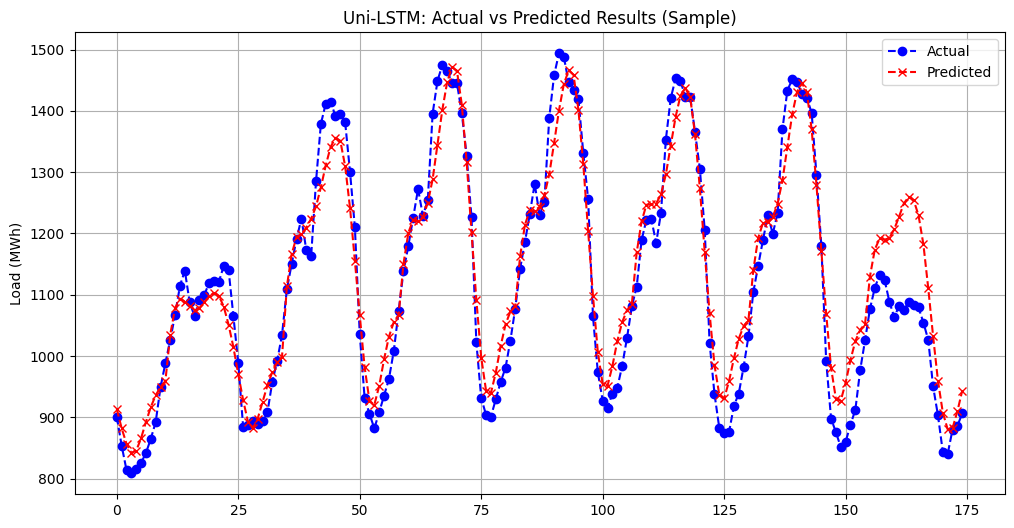

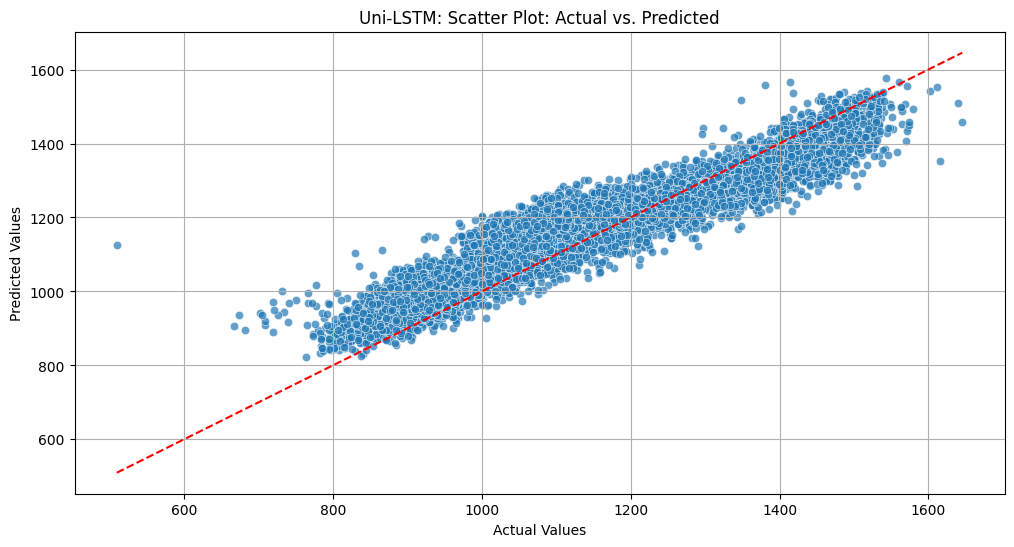

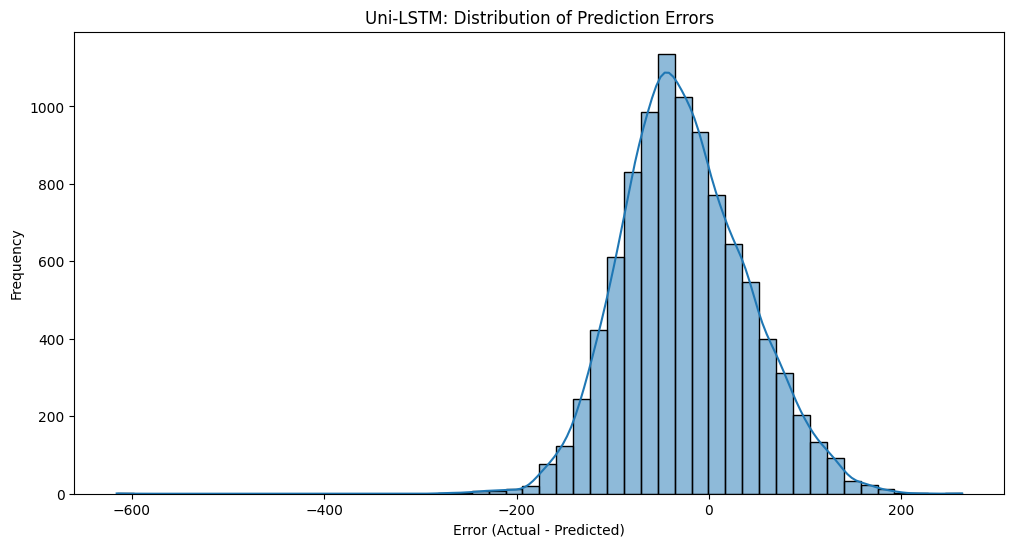

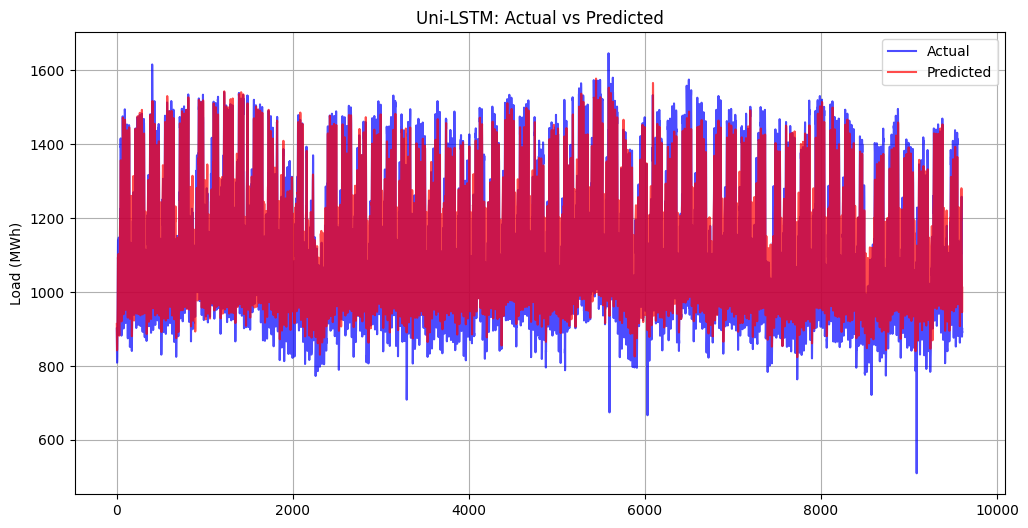

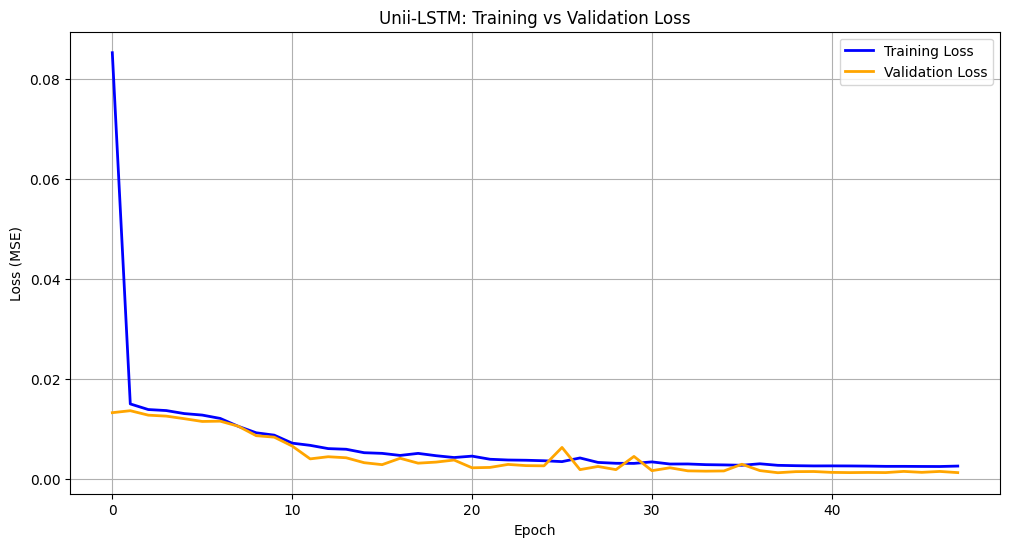

In [3]:
pyplot.figure(figsize=(12, 6))
pyplot.plot(actual[:175], label='Actual', color="blue", marker='o', linestyle='dashed')
pyplot.plot(predicted[:175], label='Predicted', color="red", marker='x', linestyle='dashed')
#pyplot.xlabel("Time Steps")
pyplot.ylabel("Load (MWh)")
pyplot.title("Uni-LSTM: Actual vs Predicted Results (Sample)")
pyplot.legend()
pyplot.grid(True)
pyplot.show()

actual = np.array(actual).flatten()
predicted = np.array(predicted).flatten()

pyplot.figure(figsize=(12, 6))
sns.scatterplot(x=actual, y=predicted, alpha=0.7)
pyplot.plot([min(actual), max(actual)], [min(actual), max(actual)], '--', color='red')  # Perfect fit line
pyplot.xlabel("Actual Values")
pyplot.ylabel("Predicted Values")
pyplot.title("Uni-LSTM: Scatter Plot: Actual vs. Predicted")
pyplot.grid(True)
pyplot.show()

errors = actual - predicted
pyplot.figure(figsize=(12, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title("Uni-LSTM: Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")

pyplot.figure(figsize=(12, 6))
pyplot.plot(actual, label='Actual', color="blue", alpha=0.7)
pyplot.plot(predicted, label='Predicted', color="red", alpha=0.7)
#pyplot.xlabel("Time Steps")
pyplot.ylabel("Load (MWh)")
pyplot.title("Uni-LSTM: Actual vs Predicted")
pyplot.legend()
pyplot.grid(True)
pyplot.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title("Unii-LSTM: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Bi-LSTM


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LSTM, Bidirectional
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

def get_data(normalized=0):
    df = pd.read_excel(r"/content/drive/MyDrive/Demand Forecasting/dataset.xlsx")
    df.columns = ["Time", "Load", "Temperature", "Humidity", "Liquid", "Wind", "Holiday", "School"]
    df = df[1:]  # drop duplicated header
    df["Time"] = pd.to_datetime(df["Time"])
    df["Day"] = df["Time"].dt.day
    df["Month"] = df["Time"].dt.month
    df["Hour"] = df["Time"].dt.hour * 3600  # encode hour as seconds

    # Final columns to use (reorder for modeling)
    df = df[[
        "Day", "Month", "Hour",
        "Temperature", "Humidity", "Liquid", "Wind",
        "Holiday", "School", "Load"
    ]]
    return df

def load_data(my_data, seq_len):
    amount_of_features = len(my_data.columns)
    data = my_data.values
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
    return [x_train, y_train, x_test, y_test]


df = get_data(0)
# min_max_scaler = preprocessing.MinMaxScaler()
# nomalized = min_max_scaler.fit_transform(df.values)
values = df.values
minima = np.amin(values[:, -1])
maxima = np.amax(values[:, -1])
scaling_parameter = maxima - minima
# Normalize all features except the target (last column)
for i in range(values.shape[1] - 1):
    values[:, i] = (values[:, i] - np.amin(values[:, i])) / (np.amax(values[:, i]) - np.amin(values[:, i]))

# Normalize target load
values[:, -1] = (values[:, -1] - minima) / scaling_parameter

df = pd.DataFrame(values)
window = 12
X_train, y_train, X_test, y_test = load_data(df[::-1], window)

def build_model(layers):
    d = 0.5
    model = Sequential()
    model.add(Bidirectional(LSTM(512, return_sequences=False, recurrent_dropout=0.2)))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

early_stop = EarlyStopping(
    monitor='val_loss',       # monitor validation loss
    patience=10,              # stop if no improvement for 10 epochs
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # reduce LR when val_loss plateaus
    factor=0.5,               # reduce by 50%
    patience=5,               # wait 5 epochs before reducing
    min_lr=1e-6               # don’t go lower than this
)

model = build_model([9,window,1])
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=200,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stop, lr_scheduler])

from matplotlib import pyplot
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predicted = model.predict(X_test)
actual = y_test

predicted = (predicted*scaling_parameter)+minima
actual = (actual*scaling_parameter)+minima

mape = sqrt(mean_absolute_percentage_error(actual, predicted))
r2 = r2_score(actual, predicted)

metrics_df = pd.DataFrame({
    "Metric": ["MAPE (%)", "R² Score"],
    "Value": [mape, r2]
})

metrics_df["Value"] = metrics_df["Value"].round(3)
metrics_df

Epoch 1/200
31/31 - 10s - 314ms/step - loss: 0.0874 - mae: 0.2252 - val_loss: 0.0124 - val_mae: 0.0953 - learning_rate: 1.0000e-03
Epoch 2/200
31/31 - 4s - 115ms/step - loss: 0.0135 - mae: 0.0968 - val_loss: 0.0122 - val_mae: 0.0940 - learning_rate: 1.0000e-03
Epoch 3/200
31/31 - 3s - 103ms/step - loss: 0.0119 - mae: 0.0907 - val_loss: 0.0092 - val_mae: 0.0806 - learning_rate: 1.0000e-03
Epoch 4/200
31/31 - 6s - 208ms/step - loss: 0.0090 - mae: 0.0781 - val_loss: 0.0068 - val_mae: 0.0682 - learning_rate: 1.0000e-03
Epoch 5/200
31/31 - 3s - 100ms/step - loss: 0.0075 - mae: 0.0709 - val_loss: 0.0055 - val_mae: 0.0620 - learning_rate: 1.0000e-03
Epoch 6/200
31/31 - 5s - 170ms/step - loss: 0.0066 - mae: 0.0666 - val_loss: 0.0050 - val_mae: 0.0605 - learning_rate: 1.0000e-03
Epoch 7/200
31/31 - 6s - 197ms/step - loss: 0.0055 - mae: 0.0603 - val_loss: 0.0069 - val_mae: 0.0678 - learning_rate: 1.0000e-03
Epoch 8/200
31/31 - 4s - 127ms/step - loss: 0.0048 - mae: 0.0558 - val_loss: 0.0032 - val

,Metric,Value
0,MAPE (%),4.386
1,R² Score,0.927


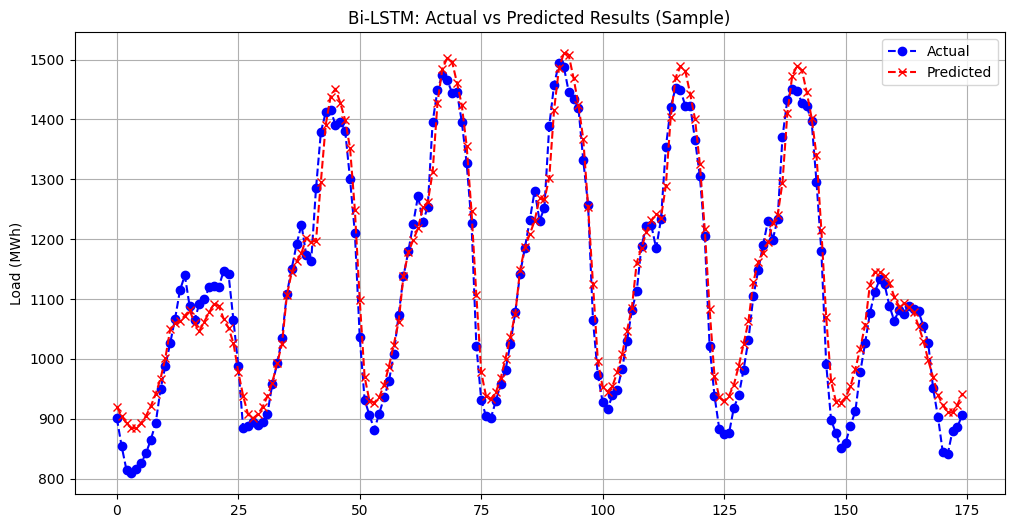

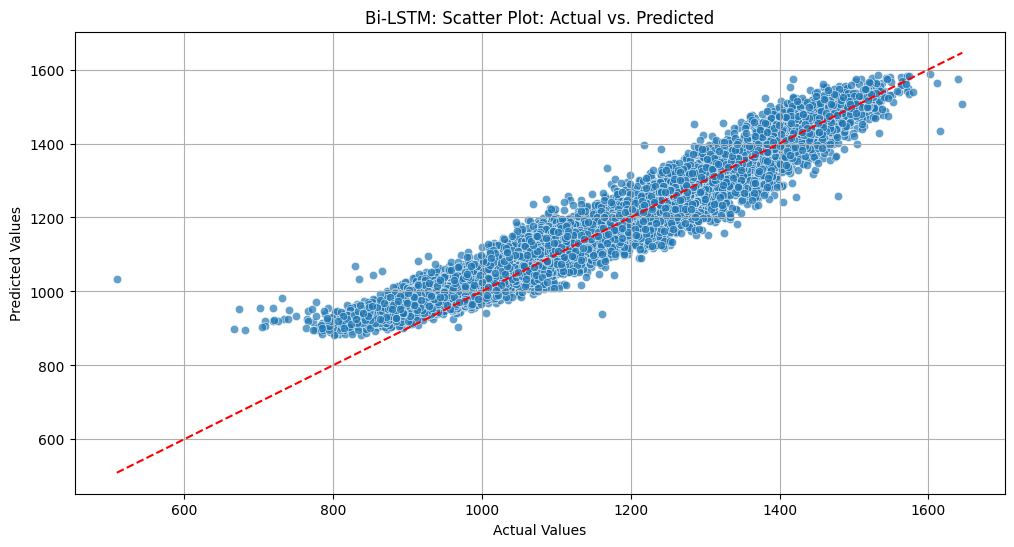

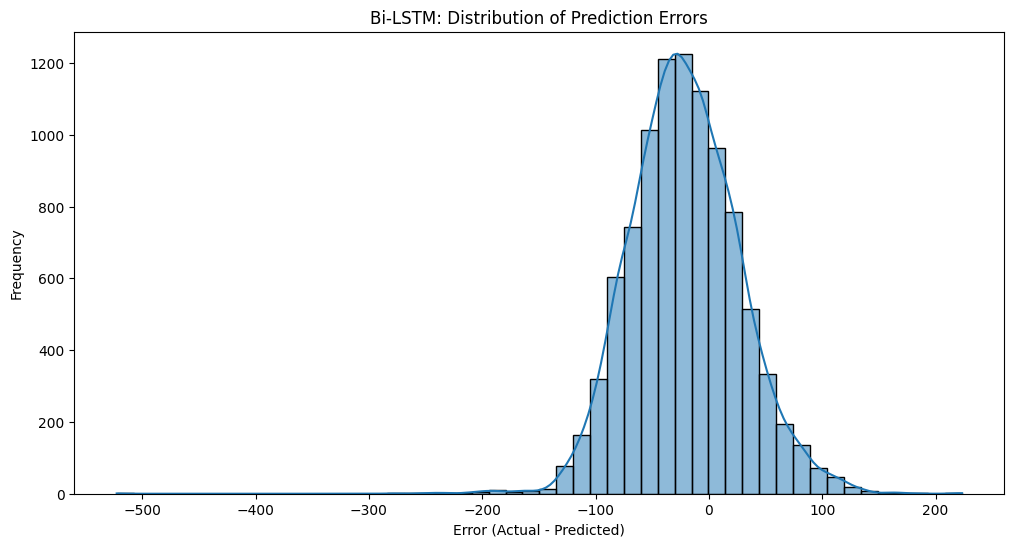

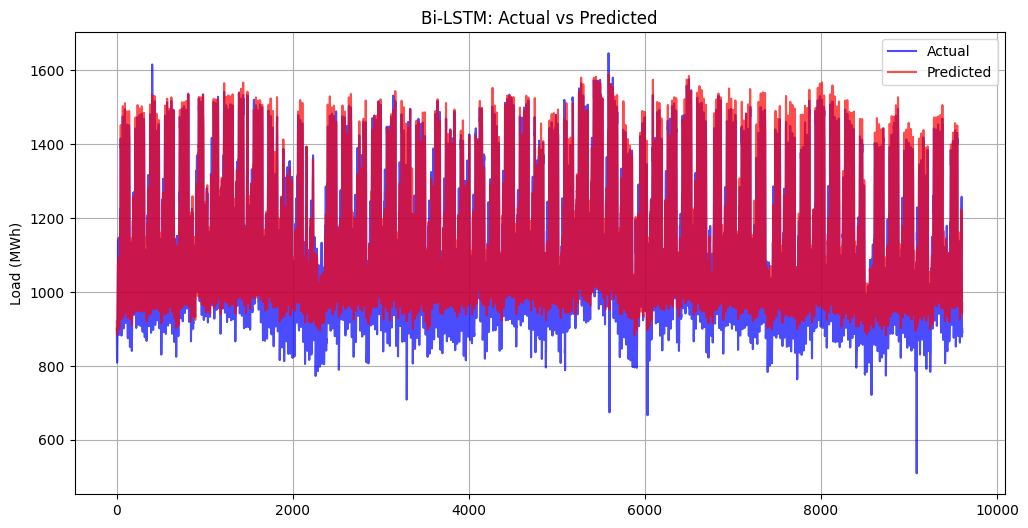

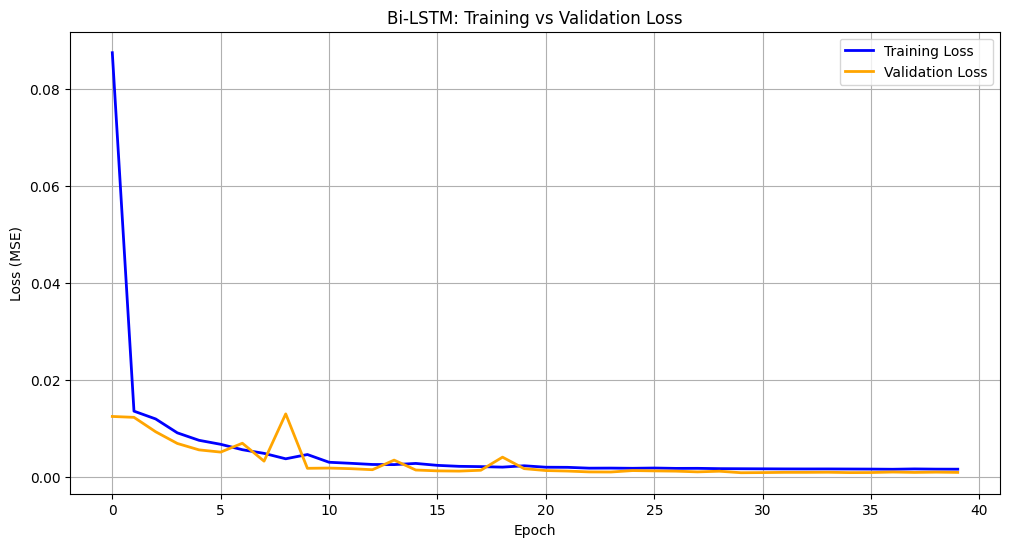

In [5]:
pyplot.figure(figsize=(12, 6))
pyplot.plot(actual[:175], label='Actual', color="blue", marker='o', linestyle='dashed')
pyplot.plot(predicted[:175], label='Predicted', color="red", marker='x', linestyle='dashed')
#pyplot.xlabel("Time Steps")
pyplot.ylabel("Load (MWh)")
pyplot.title("Bi-LSTM: Actual vs Predicted Results (Sample)")
pyplot.legend()
pyplot.grid(True)
pyplot.show()

actual = np.array(actual).flatten()
predicted = np.array(predicted).flatten()

pyplot.figure(figsize=(12, 6))
sns.scatterplot(x=actual, y=predicted, alpha=0.7)
pyplot.plot([min(actual), max(actual)], [min(actual), max(actual)], '--', color='red')  # Perfect fit line
pyplot.xlabel("Actual Values")
pyplot.ylabel("Predicted Values")
pyplot.title("Bi-LSTM: Scatter Plot: Actual vs. Predicted")
pyplot.grid(True)
pyplot.show()

errors = actual - predicted
pyplot.figure(figsize=(12, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title("Bi-LSTM: Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")

pyplot.figure(figsize=(12, 6))
pyplot.plot(actual, label='Actual', color="blue", alpha=0.7)
pyplot.plot(predicted, label='Predicted', color="red", alpha=0.7)
#pyplot.xlabel("Time Steps")
pyplot.ylabel("Load (MWh)")
pyplot.title("Bi-LSTM: Actual vs Predicted")
pyplot.legend()
pyplot.grid(True)
pyplot.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title("Bi-LSTM: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Double Bi-LSTM

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LSTM, Bidirectional
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

def get_data(normalized=0):
    df = pd.read_excel(r"/content/drive/MyDrive/Demand Forecasting/dataset.xlsx")
    df.columns = ["Time", "Load", "Temperature", "Humidity", "Liquid", "Wind", "Holiday", "School"]
    df = df[1:]  # drop duplicated header
    df["Time"] = pd.to_datetime(df["Time"])
    df["Day"] = df["Time"].dt.day
    df["Month"] = df["Time"].dt.month
    df["Hour"] = df["Time"].dt.hour * 3600  # encode hour as seconds

    # Final columns to use (reorder for modeling)
    df = df[[
        "Day", "Month", "Hour",
        "Temperature", "Humidity", "Liquid", "Wind",
        "Holiday", "School", "Load"
    ]]
    return df

def load_data(my_data, seq_len):
    amount_of_features = len(my_data.columns)
    data = my_data.values
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
    return [x_train, y_train, x_test, y_test]


df = get_data(0)
# min_max_scaler = preprocessing.MinMaxScaler()
# nomalized = min_max_scaler.fit_transform(df.values)
values = df.values
minima = np.amin(values[:, -1])
maxima = np.amax(values[:, -1])
scaling_parameter = maxima - minima
# Normalize all features except the target (last column)
for i in range(values.shape[1] - 1):
    values[:, i] = (values[:, i] - np.amin(values[:, i])) / (np.amax(values[:, i]) - np.amin(values[:, i]))

# Normalize target load
values[:, -1] = (values[:, -1] - minima) / scaling_parameter

df = pd.DataFrame(values)
window = 12
X_train, y_train, X_test, y_test = load_data(df[::-1], window)

def build_model(layers):
    d = 0.5
    model = Sequential()
    model.add(Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Dropout(d))
    model.add(Bidirectional(LSTM(256, return_sequences=False)))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

early_stop = EarlyStopping(
    monitor='val_loss',       # monitor validation loss
    patience=10,              # stop if no improvement for 10 epochs
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # reduce LR when val_loss plateaus
    factor=0.5,               # reduce by 50%
    patience=5,               # wait 5 epochs before reducing
    min_lr=1e-6               # don’t go lower than this
)

model = build_model([9,window,1])
history = model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=200,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stop, lr_scheduler])

from matplotlib import pyplot
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predicted = model.predict(X_test)
actual = y_test

predicted = (predicted*scaling_parameter)+minima
actual = (actual*scaling_parameter)+minima

mape = sqrt(mean_absolute_percentage_error(actual, predicted))
r2 = r2_score(actual, predicted)

metrics_df = pd.DataFrame({
    "Metric": ["MAPE (%)", "R² Score"],
    "Value": [mape, r2]
})

metrics_df["Value"] = metrics_df["Value"].round(3)
metrics_df

Epoch 1/200
31/31 - 14s - 458ms/step - loss: 0.0680 - mae: 0.1833 - val_loss: 0.0130 - val_mae: 0.0979 - learning_rate: 1.0000e-03
Epoch 2/200
31/31 - 9s - 285ms/step - loss: 0.0147 - mae: 0.1009 - val_loss: 0.0130 - val_mae: 0.0979 - learning_rate: 1.0000e-03
Epoch 3/200
31/31 - 10s - 326ms/step - loss: 0.0141 - mae: 0.0986 - val_loss: 0.0128 - val_mae: 0.0973 - learning_rate: 1.0000e-03
Epoch 4/200
31/31 - 6s - 183ms/step - loss: 0.0135 - mae: 0.0965 - val_loss: 0.0130 - val_mae: 0.0977 - learning_rate: 1.0000e-03
Epoch 5/200
31/31 - 10s - 324ms/step - loss: 0.0128 - mae: 0.0937 - val_loss: 0.0116 - val_mae: 0.0923 - learning_rate: 1.0000e-03
Epoch 6/200
31/31 - 5s - 169ms/step - loss: 0.0107 - mae: 0.0851 - val_loss: 0.0089 - val_mae: 0.0752 - learning_rate: 1.0000e-03
Epoch 7/200
31/31 - 5s - 169ms/step - loss: 0.0088 - mae: 0.0754 - val_loss: 0.0051 - val_mae: 0.0576 - learning_rate: 1.0000e-03
Epoch 8/200
31/31 - 10s - 331ms/step - loss: 0.0065 - mae: 0.0643 - val_loss: 0.0051 - 

,Metric,Value
0,MAPE (%),4.414
1,R² Score,0.963


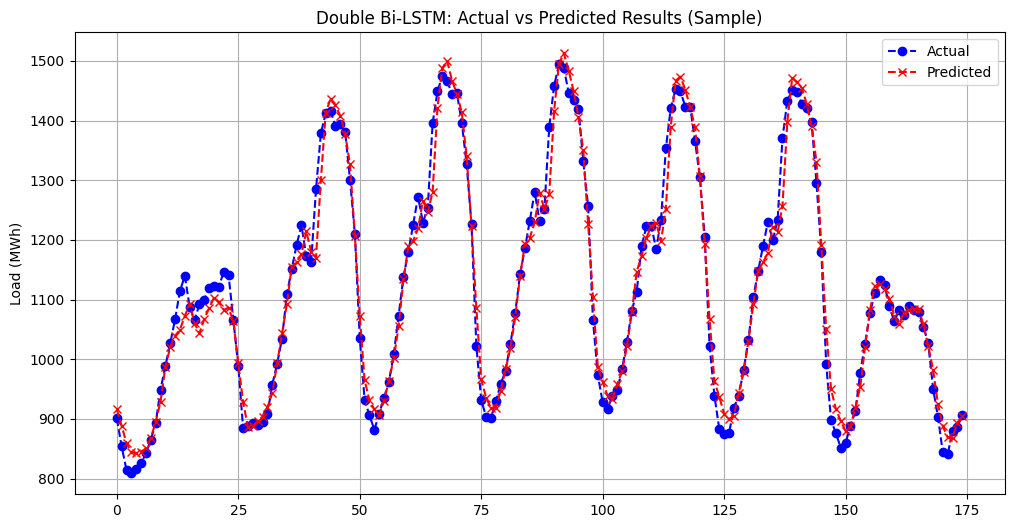

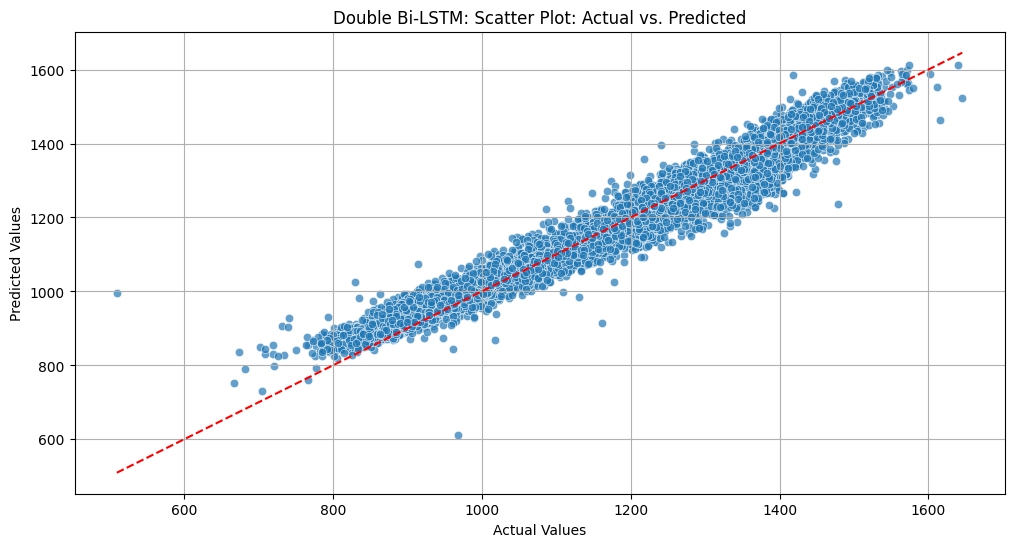

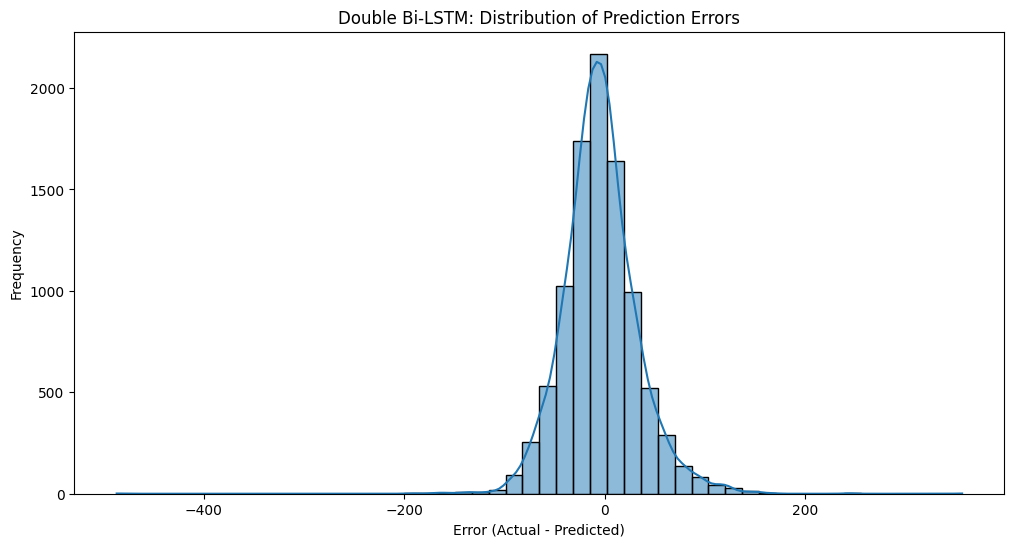

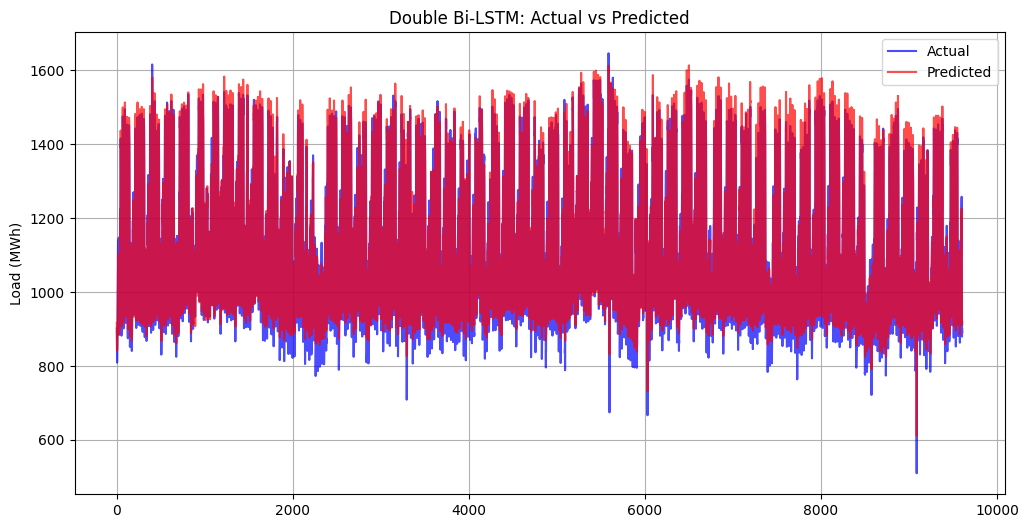

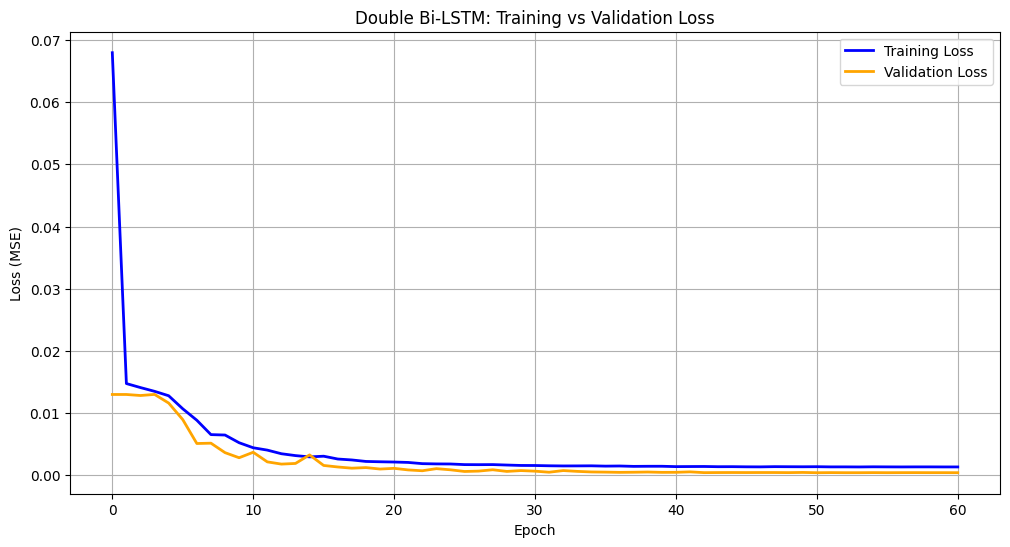

In [7]:
pyplot.figure(figsize=(12, 6))
pyplot.plot(actual[:175], label='Actual', color="blue", marker='o', linestyle='dashed')
pyplot.plot(predicted[:175], label='Predicted', color="red", marker='x', linestyle='dashed')
#pyplot.xlabel("Time Steps")
pyplot.ylabel("Load (MWh)")
pyplot.title("Double Bi-LSTM: Actual vs Predicted Results (Sample)")
pyplot.legend()
pyplot.grid(True)
pyplot.show()

actual = np.array(actual).flatten()
predicted = np.array(predicted).flatten()

pyplot.figure(figsize=(12, 6))
sns.scatterplot(x=actual, y=predicted, alpha=0.7)
pyplot.plot([min(actual), max(actual)], [min(actual), max(actual)], '--', color='red')  # Perfect fit line
pyplot.xlabel("Actual Values")
pyplot.ylabel("Predicted Values")
pyplot.title("Double Bi-LSTM: Scatter Plot: Actual vs. Predicted")
pyplot.grid(True)
pyplot.show()

errors = actual - predicted
pyplot.figure(figsize=(12, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title("Double Bi-LSTM: Distribution of Prediction Errors")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")

pyplot.figure(figsize=(12, 6))
pyplot.plot(actual, label='Actual', color="blue", alpha=0.7)
pyplot.plot(predicted, label='Predicted', color="red", alpha=0.7)
#pyplot.xlabel("Time Steps")
pyplot.ylabel("Load (MWh)")
pyplot.title("Double Bi-LSTM: Actual vs Predicted")
pyplot.legend()
pyplot.grid(True)
pyplot.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title("Double Bi-LSTM: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()